<a href="https://colab.research.google.com/github/CaptainOmerica/OpenCVPython/blob/master/Clustering_Image_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive
(You don't need to run this section) 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping and extracting files into a Folder

In [4]:
#Importing the Libraries
import zipfile
import os

zip_ref=zipfile.ZipFile('/content/drive/MyDrive/worm_image_data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/WormZ') #Extracts the files into the /Temporary folder
zip_ref.close()



---



---


# **Unsupervised Clustering of Worm Data** ⚛

Workflow Pipeline:
1.   Import Images into an Image Array (this took me a day ;-;)
2.   Dimensionality Reduction (using pre-trained VGG16 network from Keras API)
3. K- Means Clustering (with K=6; that's roughly the number of classes we came up with)



Importing Relevant Libraries

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import keras
import os

Generating an list of Image titles in the worm folder

In [2]:
path='/WormZ/image_data3/worm/'
worm_pics=[]
for filename in os.listdir(path):
    if filename.endswith("png"): 
        # Your code comes here such as 
        worm_pics.append(filename)
print('Total Worm Pictures: '+ str(len(worm_pics)))

Total Worm Pictures: 7929


Using *worm_pics* to access each Image and reading it with Open CV into an **"Image Array"**

Reference: https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
(But I've modified his function to meet our needs)

In [9]:
#Defining a Function
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
  images=[]
  # Define empty arrays where we will store our images
  for file in codes:               
    # build file path
    file_path = path+file
    #Read the image
    #image = cv2.imread(file_path)
    grayImage = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(grayImage, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) #BINARY IMAGE
    image = np.stack((im_bw,)*3, axis=-1); #since the VGG16 only accepts 3 channels so putting grayscale image into 3 channels
    # Resize it to 224 x 224 for use with VGG16 model
    image = cv2.resize(image, (224,224))
    #Now we add it to our array
    images.append(image)
  return images

Using the function *load_images()* on *worm_pics*

In [10]:
worm_pix=load_images(worm_pics)

Trying to Plot an Image from *worm_pix*

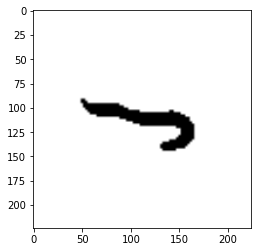

In [11]:
plt.imshow(worm_pix[75])

Normalizing Image (Dividing by 255) so that it can be fed into VGG16

In [12]:
def normalise_images(images):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)

    # Normalise the images
    images /= 255
    
    return images

In [13]:
worm_pix_normd=normalise_images(worm_pix)

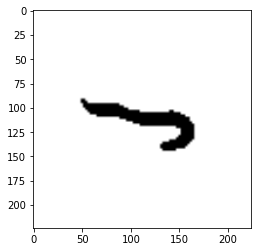

In [14]:
plt.imshow(worm_pix_normd[75])


**Loading the VGG16 model for Feature Extraction**

Reference: https://franky07724-57962.medium.com/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1

**Why this step?** To extract features out of the worm pictures through the layers of VGG16 model. This will help reduce dimensionality and can then be used for K-means

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


In [16]:
# Load the models with ImageNet weights
model = VGG16(weights='imagenet', include_top=False)
model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Proving the Dimensionality Reduction by feeding an Image to the VGG16 Network for Feature Extraction

In [17]:
vgg16_feature_list = []

pic=worm_pix_normd[2]
pic = np.expand_dims(pic, axis=0)
print('Original Dimensions/image:' + str(pic.size))
vgg16_feature = model.predict(pic)
vgg16_feature_np = np.array(vgg16_feature)
print('Reduced Features/image (with VGG16): ' +str(vgg16_feature_np.size))


Original Dimensions/image:150528
Reduced Features/image (with VGG16): 25088


**Conclusion:** The VGG16 network layers do perform some kind of feature extraction from the image...



# Extracting Features 
I'm only extracting features out of the first 500 pictures here because the feature-extraction process takes a lot of time. I tried training it over all 7929 worm pictures and it took an hour... and then my Colab crashed...

**Note:** This will take about 4 minutes to Train...

In [18]:
#Feature Extraction on first 500 pictures
for pic in worm_pix_normd[0:500]:
  pic = np.expand_dims(pic, axis=0)
  vgg16_feature = model.predict(pic)
  vgg16_feature_np = np.array(vgg16_feature)
  vgg16_feature_list.append(vgg16_feature_np.flatten())

This is the new Image List with extracted Features

In [67]:
vgg16_feature_list_np = np.array(vgg16_feature_list)
np.size(vgg16_feature_list_np)

12544000

In [45]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(vgg16_feature_list_np)

**Checking out the Clustered Images**


> The *cluster_labels* table shows the cluster that each image from the 500 images belongs to



In [68]:
cluster_labels=kmeans.fit_predict(vgg16_feature_list_np)
cluster_labels

array([5, 1, 3, 5, 4, 1, 3, 1, 4, 3, 1, 2, 1, 4, 4, 1, 0, 2, 0, 3, 3, 4,
       0, 4, 3, 3, 0, 5, 0, 1, 0, 0, 1, 5, 4, 1, 3, 5, 4, 0, 4, 0, 1, 0,
       0, 1, 2, 5, 4, 0, 0, 0, 5, 1, 1, 0, 5, 1, 0, 1, 4, 1, 1, 1, 5, 2,
       0, 2, 4, 5, 5, 2, 2, 2, 2, 4, 0, 4, 5, 2, 3, 1, 3, 3, 4, 2, 5, 5,
       5, 3, 1, 1, 0, 0, 2, 3, 0, 0, 2, 3, 5, 4, 1, 1, 1, 0, 0, 2, 2, 0,
       1, 1, 5, 4, 0, 5, 5, 0, 1, 3, 4, 4, 0, 5, 3, 3, 0, 3, 1, 4, 1, 2,
       5, 1, 0, 5, 5, 3, 0, 5, 4, 1, 3, 1, 5, 2, 2, 0, 0, 1, 4, 1, 4, 4,
       2, 2, 4, 1, 4, 5, 2, 5, 4, 4, 4, 2, 4, 5, 1, 2, 5, 4, 3, 2, 2, 0,
       5, 2, 1, 2, 2, 2, 4, 0, 3, 3, 1, 1, 1, 3, 1, 0, 4, 1, 4, 1, 5, 2,
       3, 5, 4, 1, 3, 2, 0, 4, 2, 3, 4, 5, 5, 3, 5, 0, 3, 4, 1, 1, 4, 4,
       0, 5, 3, 4, 3, 4, 2, 2, 5, 3, 4, 4, 5, 2, 4, 1, 1, 0, 4, 3, 5, 4,
       4, 5, 5, 3, 4, 4, 3, 1, 5, 4, 4, 2, 1, 0, 2, 2, 1, 2, 2, 4, 4, 2,
       2, 1, 3, 0, 2, 4, 3, 0, 5, 5, 1, 0, 0, 5, 1, 0, 0, 4, 0, 2, 2, 0,
       0, 3, 0, 2, 4, 4, 3, 4, 1, 5, 2, 0, 5, 4, 4,

Finding Indexes of Each Cluster 

In [69]:
class0_idx=[]
class1_idx=[]
class2_idx=[]
class3_idx=[]
class4_idx=[]
class5_idx=[]
for i in range(len(cluster_labels)):
  if cluster_labels[i]==0:
    class0_idx.append(i)
  elif cluster_labels[i]==1:
    class1_idx.append(i)
  elif cluster_labels[i]==2:
    class2_idx.append(i)
  elif cluster_labels[i]==3:
    class3_idx.append(i)
  elif cluster_labels[i]==4:
    class4_idx.append(i)
  elif cluster_labels[i]==5:
    class5_idx.append(i)


**Frequency of each Cluster**

In [70]:

unique, counts = np.unique(cluster_labels, return_counts=True)

print(np.asarray((unique, counts)))

[[  0   1   2   3   4   5]
 [102  92  75  54 104  73]]


**Plotting Cluster 5**

In [71]:
elements=class5_idx[0:33]

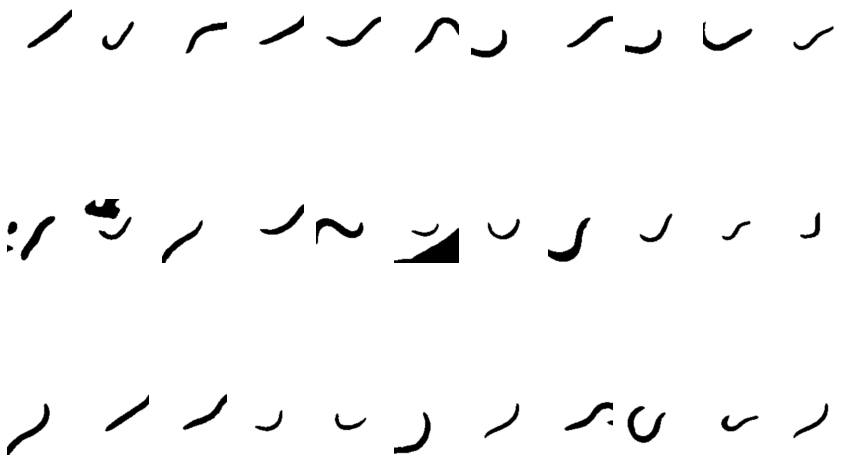

In [72]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**Plotting Cluster 0**

In [73]:
elements=class0_idx[0:33]

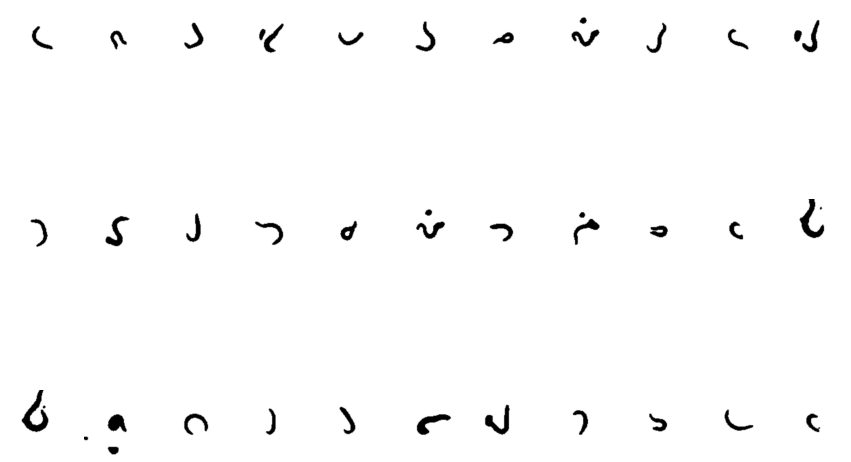

In [74]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**Plotting Cluster 2**

In [75]:
elements=class2_idx[0:33]

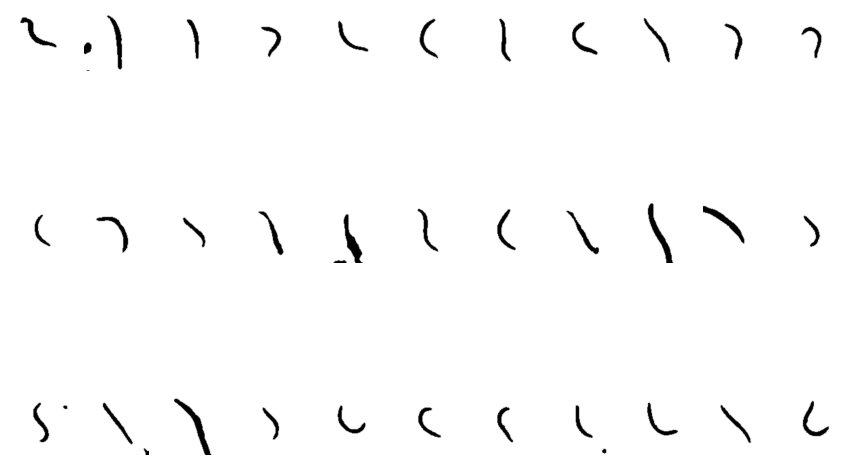

In [76]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**Cluster 4**

In [77]:
elements=class4_idx[0:33]

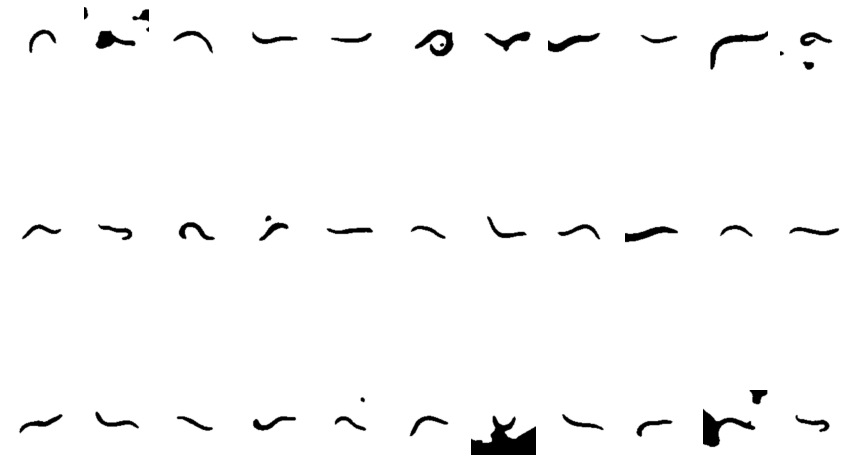

In [78]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**Cluster 1**

In [79]:
elements=class1_idx[0:33]

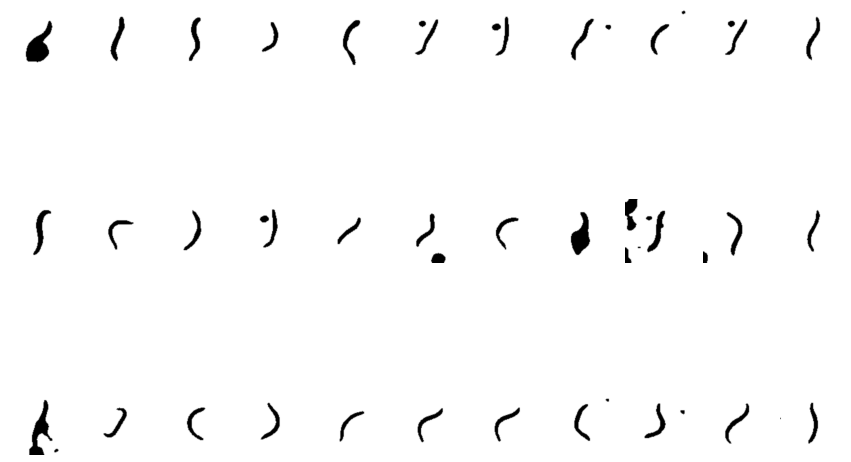

In [80]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**Cluster 3** (NOISE CLASS)

In [81]:
elements=class3_idx[0:33]

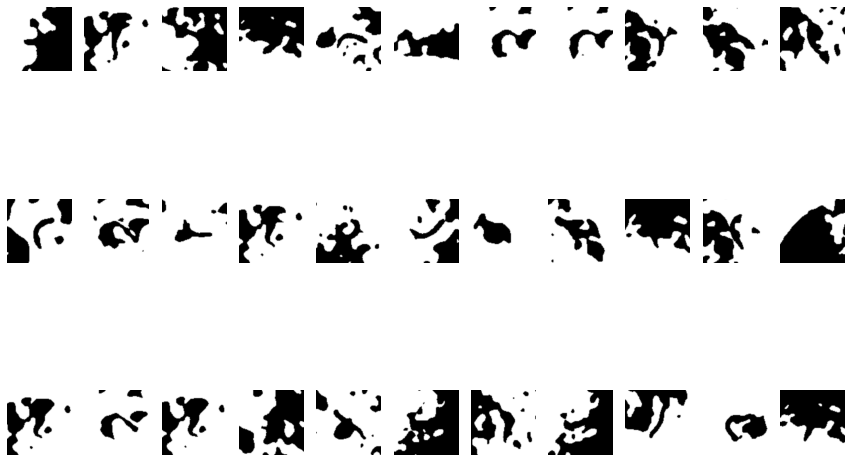

In [82]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')




---



---


## **Semi-Supervised Clustering**

Finding the Index of the "ideal" images based on their filenames (manually found)

In [83]:
q_mark=worm_pics.index('IMG_2019-09-06_Kratom RMD etoh10_kratom rmd etoh 122928.png') #Question Mark
s=worm_pics.index('IMG_2019-09-06_kratom rmd h20 04.04 2_kratom rmd h20 5 04.043108.png') #S
J=worm_pics.index('IMG_2020-06-24_NL 5901 no compound + FUdR_M-no comp worm 26108.png') #J
three=worm_pics.index('IMG_2020-06-24_NL 5901 no compound + FUdR_M-no comp worm 171020.png') #3
o=worm_pics.index('IMG_2019-12-19_CL2122_M-Movie0024744.png') #o
I=worm_pics.index('IMG_2019-09-06_kratom rmd h20 04.04 2_kratom rmd h20 9 04.041092.png') #I (straight worm)
C=worm_pics.index('IMG_2020-06-24_NL5901 1 week old_Levodopa_M-nl 5901 levodopa 1 week old 191404.png') #C

indexes=[q_mark,s,J,three,o,I,C]

Appending the ideal pictures to a list called ideal_pics

In [84]:
ideal_pics=[]
for index in indexes:
  ideal_pics.append(worm_pix_normd[index])

Visualizing the 7 ideal pictures

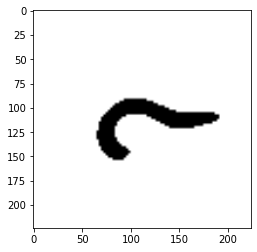

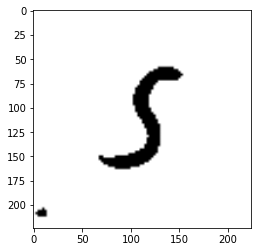

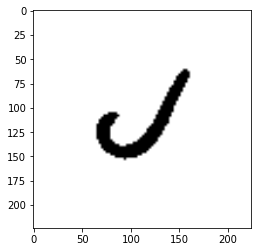

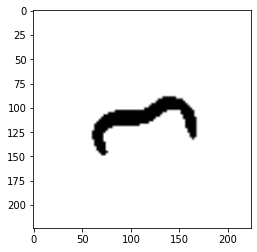

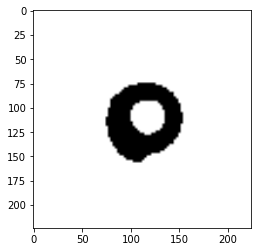

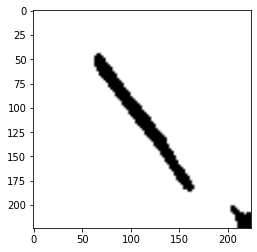

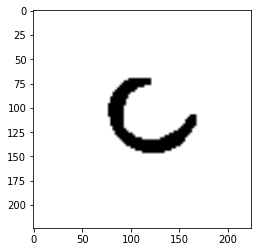

In [85]:
for i in range(len(ideal_pics)):
    plt.figure()
    plt.imshow(ideal_pics[i])
    # Show/save figure as desired.
    plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
plt.show()

Extracting Features out of these Ideal pictures through VGG16 (Dimensionality Reduction)

In [86]:
ideal_pics_vgg16=[] #intializing the list for features extracted out of these ideal pictures
for pic in ideal_pics:
  pic = np.expand_dims(pic, axis=0)
  vgg16_feature = model.predict(pic)
  vgg16_feature_np = np.array(vgg16_feature)
  ideal_pics_vgg16.append(vgg16_feature_np.flatten())



# Applying K-means with 7 clusters on these ideal pics
Motivation: Initialize these 7 ideal pictures as cluster centroids of the K-means model and then fit the other pictures in it

In [87]:
#Converting it into an np array to feed into K-means
ideal_pics_vgg16_np = np.array(ideal_pics_vgg16) 

#Applying Kmeans fit with n=7
kmeans_approach2 = KMeans(n_clusters=7, random_state=0).fit(ideal_pics_vgg16_np)


Applying kmeans_approach2 to first 500 pictures

In [104]:
#Feature Extraction on 1000 pictures
vgg16_feature_list2=[]
for pic in worm_pix_normd[2000:3000]:
  pic = np.expand_dims(pic, axis=0)
  vgg16_feature = model.predict(pic)
  vgg16_feature_np = np.array(vgg16_feature)
  vgg16_feature_list2.append(vgg16_feature_np.flatten())

vgg16_feature_list2_np = np.array(vgg16_feature_list2) 

In [105]:
cluster_labels_approach2=kmeans_approach2.fit_predict(vgg16_feature_list2_np)
cluster_labels_approach2

array([6, 5, 3, 6, 0, 1, 6, 1, 6, 2, 0, 4, 4, 3, 1, 5, 3, 2, 4, 2, 5, 0,
       6, 0, 2, 5, 2, 3, 2, 0, 0, 2, 4, 5, 2, 3, 3, 2, 2, 3, 3, 6, 5, 3,
       3, 4, 5, 4, 5, 4, 5, 5, 1, 0, 3, 3, 6, 5, 3, 2, 2, 3, 6, 4, 6, 6,
       6, 2, 0, 1, 3, 0, 5, 5, 4, 5, 2, 5, 5, 6, 4, 4, 5, 2, 5, 3, 1, 5,
       1, 4, 4, 0, 3, 6, 5, 4, 6, 3, 6, 5, 3, 2, 3, 0, 0, 3, 5, 4, 4, 4,
       5, 1, 5, 2, 2, 3, 1, 6, 3, 3, 4, 5, 2, 3, 5, 5, 3, 4, 6, 6, 4, 5,
       3, 5, 3, 3, 1, 2, 3, 0, 3, 1, 5, 4, 4, 4, 5, 0, 2, 0, 0, 3, 1, 3,
       1, 6, 5, 2, 3, 6, 2, 1, 3, 5, 6, 4, 4, 4, 0, 6, 1, 2, 3, 6, 5, 0,
       1, 5, 1, 4, 3, 5, 0, 3, 6, 6, 3, 2, 3, 4, 3, 3, 3, 3, 1, 6, 5, 4,
       2, 3, 2, 0, 6, 3, 6, 3, 4, 5, 4, 3, 3, 0, 1, 0, 6, 3, 5, 3, 0, 4,
       4, 1, 4, 3, 4, 6, 0, 6, 1, 2, 4, 3, 1, 4, 2, 0, 3, 5, 6, 1, 2, 4,
       2, 4, 3, 4, 1, 6, 3, 6, 5, 5, 6, 2, 3, 3, 5, 1, 0, 5, 1, 3, 5, 1,
       5, 4, 3, 6, 3, 3, 4, 2, 5, 1, 0, 6, 4, 4, 4, 6, 3, 6, 3, 5, 2, 4,
       0, 5, 2, 1, 6, 3, 4, 2, 2, 2, 0, 3, 5, 0, 4,

Finding Indexes of images every cluster



In [106]:
q_mark_idx=[]
s_idx=[]
J_idx=[]
three_idx=[]
o_idx=[]
I_idx=[]
C_idx=[]

for i in range(len(cluster_labels_approach2)):
  if cluster_labels_approach2[i]==0:
    q_mark_idx.append(i)
  elif cluster_labels_approach2[i]==1:
    s_idx.append(i)
  elif cluster_labels_approach2[i]==2:
    J_idx.append(i)
  elif cluster_labels_approach2[i]==3:
    three_idx.append(i)
  elif cluster_labels_approach2[i]==4:
    o_idx.append(i)
  elif cluster_labels_approach2[i]==5:
    I_idx.append(i)
  elif cluster_labels_approach2[i]==6:
    C_idx.append(i)

**Question Mark Class**

In [107]:
#Generating first 22 elements 
elements=q_mark_idx[0:33]

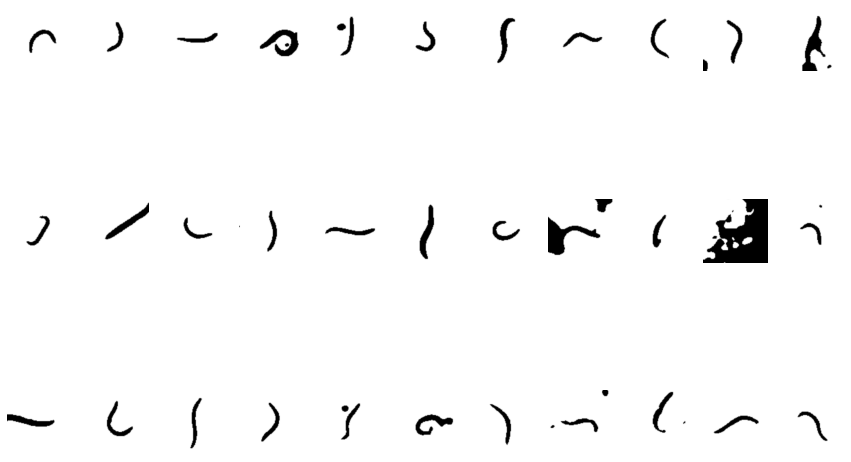

In [108]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**S Class**

In [109]:
elements=s_idx[0:33]

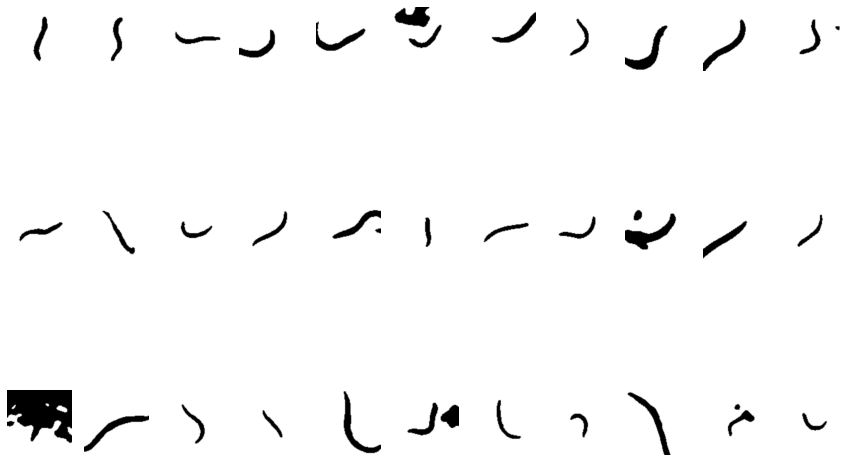

In [110]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**J Class**

In [111]:
elements=J_idx[0:32]

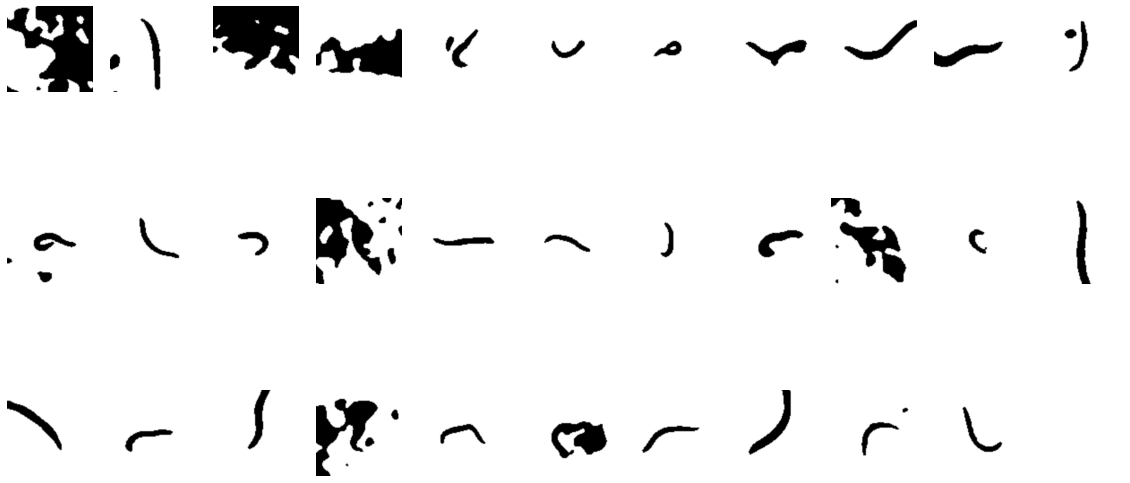

In [112]:
fig = plt.figure(figsize=(20, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**3 class** (not a good class)

In [113]:
elements=three_idx[0:32]

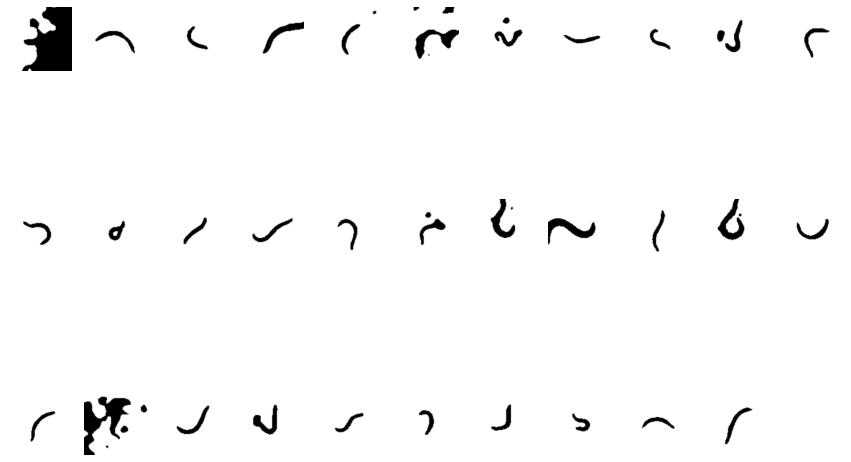

In [114]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**o-class**

In [115]:
#Generating first 33 elements 
elements=o_idx[0:32]

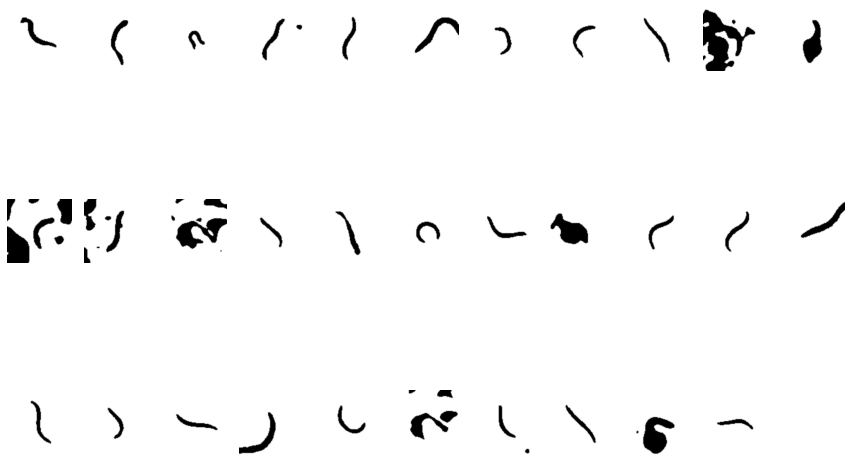

In [116]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**Remark:** The o-class isn't that good either

**I-class**

In [117]:
#Generating first 33 elements 
elements=I_idx[0:32]

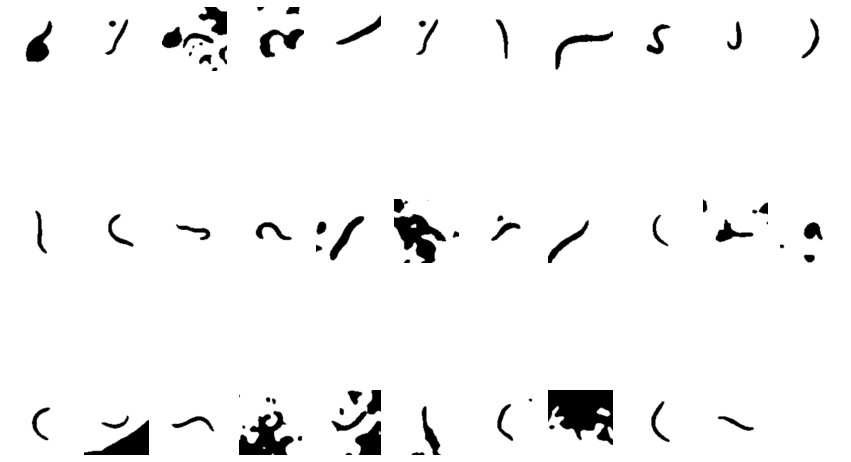

In [118]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**Remark:** I class looks terrible too

**C-class**

In [119]:
#Generating first 33 elements 
elements=C_idx[0:32]

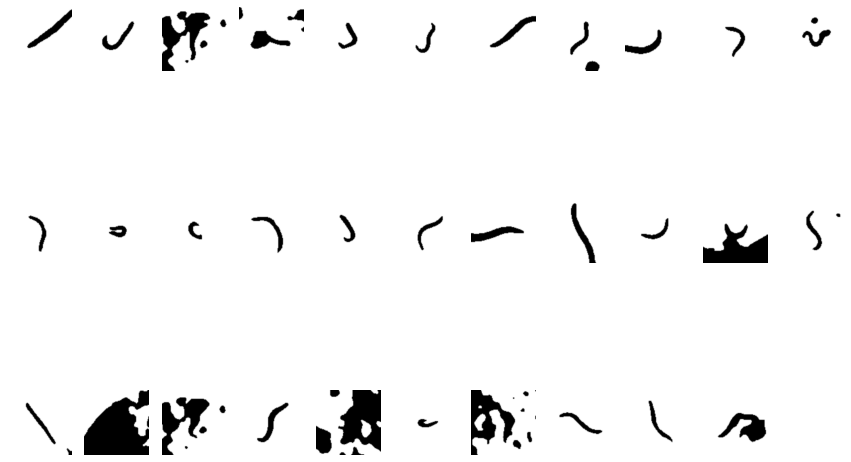

In [120]:
fig = plt.figure(figsize=(15, 10))
for count,element in enumerate(elements):
  fig.add_subplot(3, 11, count+1)
  plt.imshow(worm_pix_normd[element])
  plt.axis('off')


**Remark:** C class looks sad too